In [205]:
import pandas as pd
import numpy as np
import math

# Create Pair Data by Concatenating Features

In [206]:
def create_pair_data_concat(df, df_pair):
    df.rename(columns={'img_id': 'img_id_A'}, inplace=True)
    df_new = pd.merge(df_pair, df, on="img_id_A")
    
    df.rename(columns={'img_id_A': 'img_id_B'}, inplace=True)
    df_new = pd.merge(df_new, df, on="img_id_B")
    df.rename(columns={'img_id_B': 'img_id'}, inplace=True)
    return df_new  

# Create Pair Data by Subtracting Features

In [207]:
def create_pair_data_subtract(df, df_final):
    df_target = df_final['target']
    df.rename(columns={'img_id': 'img_id_A'}, inplace=True)
    df1 = pd.merge(df_final, df, on="img_id_A")
    df1.drop(['img_id_A','img_id_B','target'], axis=1, inplace=True)
    df.rename(columns={'img_id_A': 'img_id_B'}, inplace=True)
    df2 = pd.merge(df_final, df, on="img_id_B")
    df.rename(columns={'img_id_B': 'img_id'}, inplace=True)
    df2.drop(['img_id_A','img_id_B','target' ], axis=1, inplace=True)
    df_sub = df1.sub(df2)
    df_final = np.absolute(df_sub)
    return df_final, df_target

# Generate Training, Validation data and target

In [208]:
def GenerateTestingData(df_final, TestingPercent = 10):
    T_len = int(math.ceil(len(df_final)*0.01*TestingPercent))
    print(T_len)
    df_testing = df_final[0:T_len]
    print(df_testing)
    df_training = df_final[T_len:len(df_final)]
    return df_testing, df_training

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    return t


# Generate Raw Data

In [209]:
def generate_raw_data(df, df_diff, df_same, feature_operation, dataType):
    if feature_operation == "Concat":
        if dataType == "GSC":
            df_same = df_same.sample(n=5000)
            df_diff = df_diff.sample(n=5000)
        else:
            df_diff = df_diff.sample(n=df_same.shape[0])
        df_final = pd.concat([df_same, df_diff]).sample(frac=1).reset_index(drop=True)
        df_final = create_pair_data_concat(df, df_final)
        df_target = df_final['target']
        df_final.drop(['img_id_A','img_id_B','target' ], axis=1, inplace=True)
    if feature_operation == "Subtract":
        if dataType == "GSC":
            df_same = df_same.sample(n=5000)
            df_diff = df_diff.sample(n=5000)
        else:
            df_diff = df_diff.sample(n=df_same.shape[0])
        df_final = pd.concat([df_same, df_diff]).sample(frac=1).reset_index(drop=True)
        df_final, df_target = create_pair_data_subtract(df, df_final)
    uniques = df_final.apply(lambda x: x.nunique())
    df_final = df_final.drop(uniques[uniques==1].index, axis=1)
    return df_final, df_target   

## Model Definition

In [210]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import RMSprop

import numpy as np

#input_size = 18
drop_out = 0.04
first_dense_layer_nodes  = 150
second_dense_layer_nodes = 120
final_layer_nodes = 2

def get_model(input_size):
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
  
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    model.add(Dropout(drop_out))
    
    model.add(Dense(final_layer_nodes))
    model.add(Activation('softmax'))
    model.summary()
#     opt = RMSprop(lr=0.01)
#     model.compile(loss = "_crossentropy", optimizer = opt, metrics=['accuracy'])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Train Model

In [211]:
%matplotlib inline

def train_model(model, processedData_training, processedLabel_training):
    history = model.fit(processedData_training
                    , processedLabel_training
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )
    df = pd.DataFrame(history.history)
    df.plot(subplots=True, grid=True, figsize=(10,15))

# Calculate Accuracy

In [212]:
from sklearn.metrics import accuracy_score
def test_accuracy(model, processedData_testing):
    predictedTestLabel = model.predict(processedData_testing)
    predictedTestLabel = predictedTestLabel.argmax(axis=-1)
    testing_accuracy = accuracy_score(processedLabel_testing, predictedTestLabel)
    print("Testing Accuracy: " + str(testing_accuracy))

-----------------------HOF : Concat--------------------
-----------------------HOF : Concat--------------------


/Users/atrayeenag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/atrayeenag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


1000
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1000
[1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0
 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1
 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1
 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0
 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1
 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1
 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1
 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 

Epoch 34/10000
7200/7200 [==============================] - 1s 185us/step - loss: 0.0089 - acc: 0.9968 - val_loss: 1.9472 - val_acc: 0.6950
Epoch 35/10000
7200/7200 [==============================] - 2s 245us/step - loss: 0.0083 - acc: 0.9972 - val_loss: 1.7174 - val_acc: 0.7156
Epoch 36/10000
7200/7200 [==============================] - 2s 235us/step - loss: 0.0085 - acc: 0.9976 - val_loss: 1.5956 - val_acc: 0.7333
Epoch 37/10000
7200/7200 [==============================] - 2s 221us/step - loss: 0.0052 - acc: 0.9982 - val_loss: 1.4173 - val_acc: 0.7744
Epoch 38/10000
7200/7200 [==============================] - 2s 241us/step - loss: 0.0154 - acc: 0.9950 - val_loss: 1.8135 - val_acc: 0.6922
Epoch 39/10000
7200/7200 [==============================] - 2s 242us/step - loss: 0.0201 - acc: 0.9921 - val_loss: 1.7706 - val_acc: 0.7106
Epoch 40/10000
7200/7200 [==============================] - 1s 194us/step - loss: 0.0132 - acc: 0.9947 - val_loss: 1.6223 - val_acc: 0.7317
Epoch 41/10000
7200/

7200/7200 [==============================] - 1s 184us/step - loss: 0.0160 - acc: 0.9942 - val_loss: 1.8962 - val_acc: 0.7056
Epoch 93/10000
7200/7200 [==============================] - 1s 184us/step - loss: 0.0094 - acc: 0.9965 - val_loss: 1.4925 - val_acc: 0.7389
Epoch 94/10000
7200/7200 [==============================] - 1s 184us/step - loss: 0.0053 - acc: 0.9978 - val_loss: 1.7848 - val_acc: 0.7083
Epoch 95/10000
7200/7200 [==============================] - 1s 182us/step - loss: 0.0043 - acc: 0.9982 - val_loss: 1.9400 - val_acc: 0.6933
Epoch 96/10000
7200/7200 [==============================] - 2s 245us/step - loss: 0.0168 - acc: 0.9939 - val_loss: 1.2480 - val_acc: 0.8028
Epoch 97/10000
7200/7200 [==============================] - 2s 242us/step - loss: 0.0082 - acc: 0.9975 - val_loss: 1.4060 - val_acc: 0.7861
Epoch 98/10000
7200/7200 [==============================] - 1s 183us/step - loss: 0.0054 - acc: 0.9985 - val_loss: 1.6089 - val_acc: 0.7372
Epoch 99/10000
7200/7200 [=========

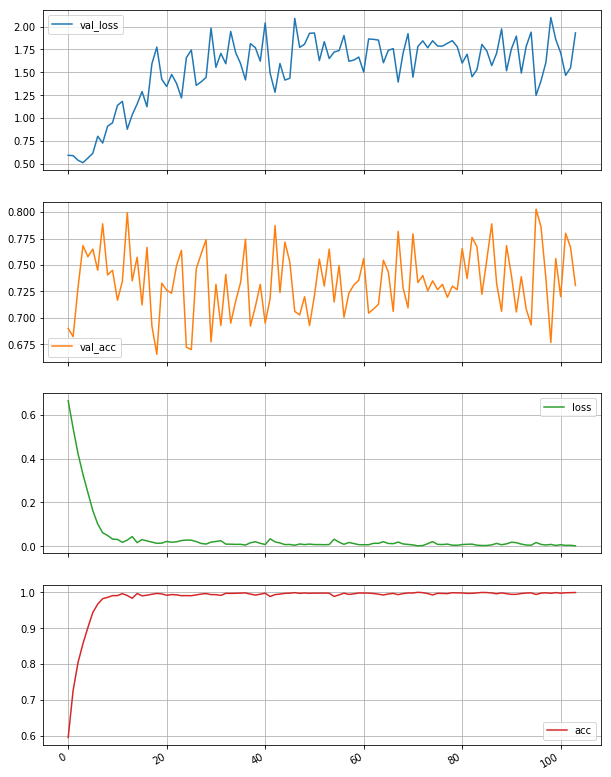

In [213]:
from keras.utils import np_utils

validation_data_split = 0.2
num_epochs = 10000  
model_batch_size = 100
tb_batch_size = 32
early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

df_hof = pd.read_csv("HOF/HumanObserved-Features-Data.csv",index_col=0)
df_diff_hof = pd.read_csv("HOF/diffn_pairs.csv")
df_same_hof = pd.read_csv("HOF/same_pairs.csv")

df_gsc = pd.read_csv("GSC/GSC-Features.csv")
df_diff_gsc = pd.read_csv("GSC/diffn_pairs.csv")
df_same_gsc = pd.read_csv("GSC/same_pairs.csv")


print("-----------------------HOF : Concat--------------------")
df_final, df_target = generate_raw_data(df_hof, df_diff_hof, df_same_hof, "Concat","HOF")
processedData_testing, processedData_training = GenerateTestingData(df_final.as_matrix())
processedLabel_testing, processedLabel_training = GenerateTestingData(df_target.as_matrix())
processedLabel_training = np_utils.to_categorical(processedLabel_training,2)
model = get_model(df_final.shape[1])
train_model(model, processedData_training, processedLabel_training)
test_accuracy(model, processedData_testing)

In [214]:
print("-----------------------HOF : Subtract--------------------")
df_final, df_target = generate_raw_data(df_gsc, df_diff_gsc, df_same_gsc, "Subtract", "HOF")
processedData_testing, processedData_training = GenerateTestingData(df_final.as_matrix())
processedLabel_testing, processedLabel_training = GenerateTestingData(df_target.as_matrix())
processedLabel_training = np_utils.to_categorical(processedLabel_training,2)
model = get_model(df_final.shape[1])
train_model(model, processedData_training, processedLabel_training)
test_accuracy(model, processedData_testing)

Testing Accuracy: 0.765


In [ ]:
print("-----------------------GSC : Concat--------------------")
df_final, df_target = generate_raw_data(df_gsc, df_diff_gsc, df_same_gsc, "Concat", "GSC")
processedData_testing, processedData_training = GenerateTestingData(df_final.as_matrix())
processedLabel_testing, processedLabel_training = GenerateTestingData(df_target.as_matrix())
processedLabel_training = np_utils.to_categorical(processedLabel_training,2)
model = get_model(df_final.shape[1])
train_model(model, processedData_training, processedLabel_training)
test_accuracy(model, processedData_testing)

In [ ]:
print("-----------------------GSC : Subtract--------------------")
df_final, df_target = generate_raw_data(df_gsc, df_diff_gsc, df_same_gsc, "Subtract", "GSC")
processedData_testing, processedData_training = GenerateTestingData(df_final.as_matrix())
processedLabel_testing, processedLabel_training = GenerateTestingData(df_target.as_matrix())
processedLabel_training = np_utils.to_categorical(processedLabel_training,2)
model = get_model(df_final.shape[1])
train_model(model, processedData_training, processedLabel_training)
test_accuracy(model, processedData_testing)